LOADING DATASET: LIVER TOXICITY
Observations (n): 64
Genes (p): 3116
Ratio p/n: 48.69
Target: Albumin (ALB.g/dL)
Range target: 4.40 - 5.60

Missing values: 0


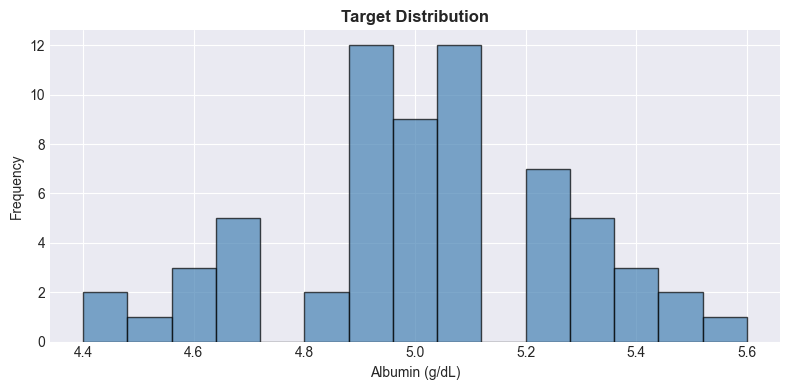

In [ ]:
# ----------------------------------------------------------------------------
# --- LOADING TOOLS AND DATA
# ----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("LOADING DATASET: LIVER TOXICITY")
print("="*60)

BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data"

X = pd.read_csv(DATA_DIR / "high_dimension/liver_gene.csv", sep=",", index_col=0)
clinic = pd.read_csv(DATA_DIR / "high_dimension/liver_clinic.csv", sep=",", index_col=0)
y = clinic['ALB.g.dL.']
n, p = X.shape

print(f"Observations (n): {n}")
print(f"Genes (p): {p}")
print(f"Ratio p/n: {p/n:.2f}")
print(f"Target: Albumin (ALB.g/dL)")
print(f"Range target: {y.min():.2f} - {y.max():.2f}")

# Check NA
na_count = X.isnull().sum().sum()
print(f"\nMissing values: {na_count}")

if na_count > 0:
    X = X.fillna(X.mean())

# Check constant values
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    print(f"Constant columns: {len(constant_cols)}")
    X = X.drop(columns=constant_cols)

# Visual target
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(y, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Albumin (g/dL)')
ax.set_ylabel('Frequency')
ax.set_title('Target Distribution', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------------------------------------------------
# --- K-FOLD CROSS-VALIDATION REGRESSION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("K-FOLD CROSS-VALIDATION")
print("="*60)

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=123)
# Feature selection inside each fold

# --- SUPPORT FUNCTIONS

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

def feature_selection_correlation(X_train, y_train, top_n=100):
    """Feature selection using correlation"""
    correlations = X_train.corrwith(y_train).abs()
    top_features = correlations.nlargest(top_n).index.tolist()
    return top_features

def feature_selection_variance(X_train, top_n=100):
    """Feature selection using variance"""
    variances = X_train.var()
    top_features = variances.nlargest(top_n).index.tolist()
    return top_features

# --- DEFINE MODELS

# *alpha in sklearn is the inverse of lambda in glmnet
models = {
    'ridge': Ridge(alpha=1.0, random_state=42),
    'lasso': Lasso(alpha=0.01, max_iter=10000, random_state=42),
    'enet': ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42),
    'rf': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    'xgb': xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3,
                            subsample=0.8, colsample_bytree=0.8, 
                            random_state=42, n_jobs=-1)
}

model_labels = {
    'ridge': 'Ridge Regression',
    'lasso': 'Lasso Regression',
    'enet': 'Elastic Net',
    'rf': 'Random Forest',
    'xgb': 'XGBoost'
}

# --- START LOOP FOR CV

predictions_all = {model_name: {'y_true': [], 'y_pred': []} 
                   for model_name in models.keys()}

fold_metrics = {model_name: [] for model_name in models.keys()}
selected_features_all = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"\n--- FOLD {fold}/{K} ---")
    
    # Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # FEATURE SELECTION (p > n)

    print(f"Feature selection: top 100 genes using correlation")
    selected_features = feature_selection_correlation(X_train, y_train, top_n=100)
    selected_features_all.append(selected_features)
    
    # Selecting...
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    print(f"Selected features: {p} → {len(selected_features)}")
    
    # Train and predict for each model
    for model_name, model in models.items():
        from sklearn.base import clone
        model_fold = clone(model)
        
        # Train
        model_fold.fit(X_train_selected, y_train)
        
        # Predict
        y_pred = model_fold.predict(X_test_selected)
        
        # Save
        predictions_all[model_name]['y_true'].extend(y_test.values)
        predictions_all[model_name]['y_pred'].extend(y_pred)
        
        # Fold Metrics
        metrics = compute_metrics(y_test, y_pred)
        fold_metrics[model_name].append(metrics)

print("\n K-Fold CV completed!")


K-FOLD CROSS-VALIDATION

--- FOLD 1/5 ---
Feature selection: top 100 genes using correlation
Selected features: 3116 → 100

--- FOLD 2/5 ---
Feature selection: top 100 genes using correlation
Selected features: 3116 → 100

--- FOLD 3/5 ---
Feature selection: top 100 genes using correlation
Selected features: 3116 → 100

--- FOLD 4/5 ---
Feature selection: top 100 genes using correlation
Selected features: 3116 → 100

--- FOLD 5/5 ---
Feature selection: top 100 genes using correlation
Selected features: 3116 → 100

 K-Fold CV completed!



PRESENTING THE RESULTS: MODELS COMPARISON

           Model  RMSE_mean  RMSE_sd  MAE_mean  R2_mean
     Elastic Net   0.189699 0.035791  0.146610 0.263119
Ridge Regression   0.191239 0.036562  0.151302 0.226076
Lasso Regression   0.192726 0.031720  0.150211 0.232959
         XGBoost   0.198238 0.032619  0.151327 0.216387
   Random Forest   0.201799 0.037327  0.155777 0.207274

Best model: Elastic Net
Mean RMSE: 0.1897 ± 0.0358
Mean R2: 0.2631

FEATURE STABILITY ANALYSIS

20 most stable genes
   1. A_43_P11285: 1.00
   2. A_42_P678904: 1.00
   3. A_42_P794613: 1.00
   4. A_42_P505480: 1.00
   5. A_42_P591665: 1.00
   6. A_43_P12448: 1.00
   7. A_43_P10088: 1.00
   8. A_42_P836392: 1.00
   9. A_43_P12913: 1.00
  10. A_42_P576823: 1.00
  11. A_42_P496340: 1.00
  12. A_43_P10005: 1.00
  13. A_43_P16774: 1.00
  14. A_42_P843603: 1.00
  15. A_42_P618538: 1.00
  16. A_43_P14916: 1.00
  17. A_42_P698972: 1.00
  18. A_42_P490786: 1.00
  19. A_42_P739929: 1.00
  20. A_42_P796502: 1.00

Stable g

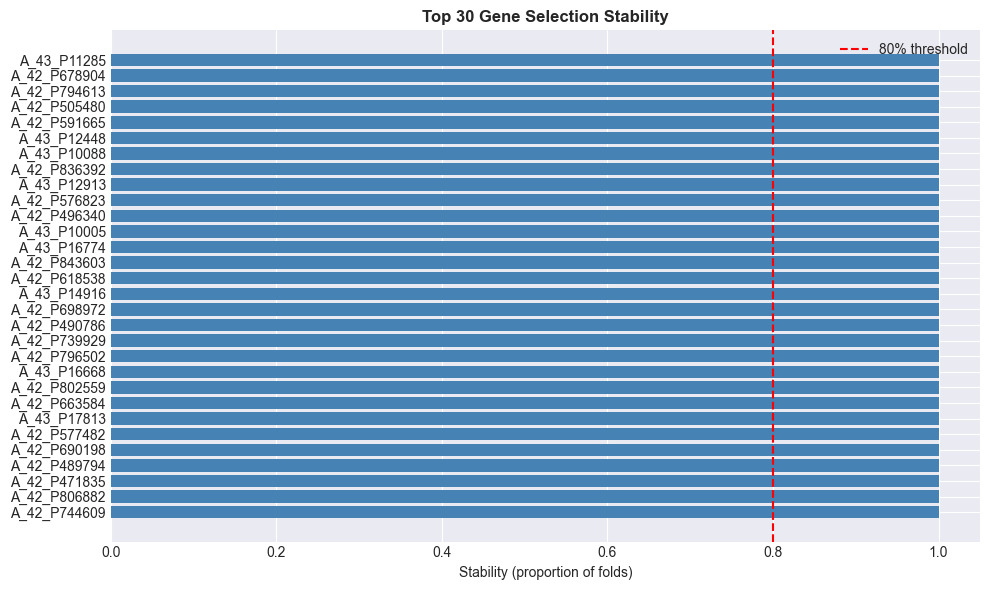

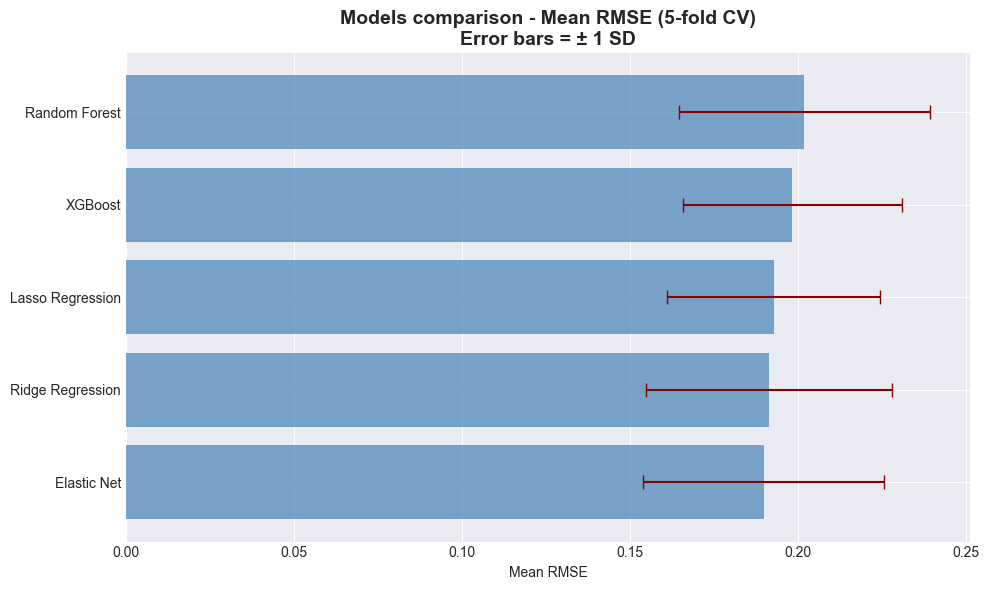

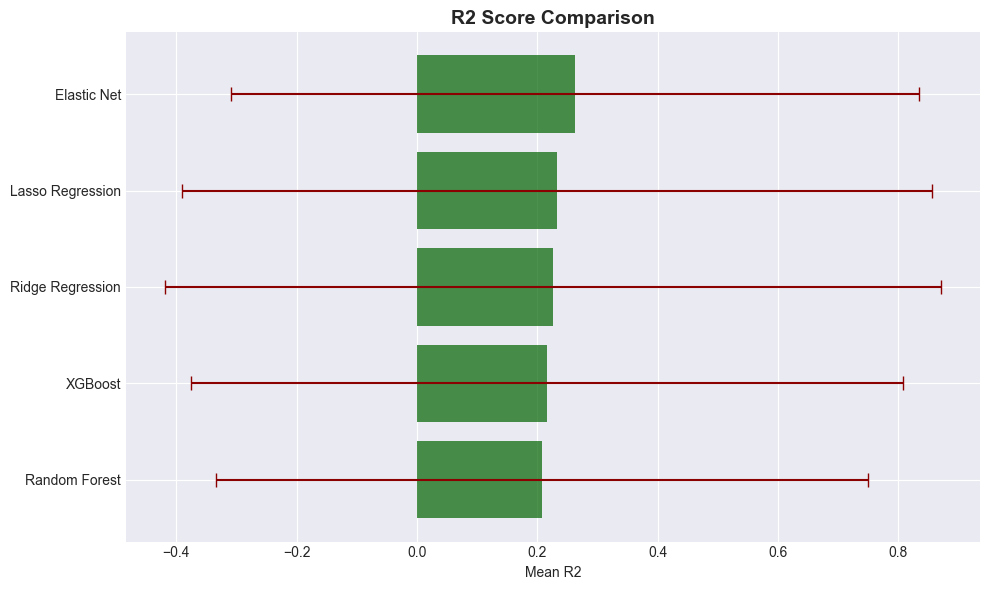

In [ ]:
# ----------------------------------------------------------------------------
# --- RESULTS AGGREGATION
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("PRESENTING THE RESULTS: MODELS COMPARISON")
print("="*60)

cv_results = []

for model_name in models.keys():
    # Metrics per fold
    rmse_folds = [m['RMSE'] for m in fold_metrics[model_name]]
    mae_folds = [m['MAE'] for m in fold_metrics[model_name]]
    r2_folds = [m['R2'] for m in fold_metrics[model_name]]
    
    # Global metrics
    y_true_all = np.array(predictions_all[model_name]['y_true'])
    y_pred_all = np.array(predictions_all[model_name]['y_pred'])
    global_metrics = compute_metrics(y_true_all, y_pred_all)
    
    cv_results.append({
        'Model': model_labels[model_name],
        'Model_Code': model_name,
        'RMSE_mean': np.mean(rmse_folds),
        'RMSE_sd': np.std(rmse_folds, ddof=1),
        'MAE_mean': np.mean(mae_folds),
        'MAE_sd': np.std(mae_folds, ddof=1),
        'R2_mean': np.mean(r2_folds),
        'R2_sd': np.std(r2_folds, ddof=1),
        'RMSE_global': global_metrics['RMSE']
    })

cv_summary = pd.DataFrame(cv_results).sort_values('RMSE_mean')

print("\n" + cv_summary[['Model', 'RMSE_mean', 'RMSE_sd', 'MAE_mean', 'R2_mean']].to_string(index=False))

# Best model
best_model_row = cv_summary.iloc[0]
best_model_name = best_model_row['Model']
best_model_code = best_model_row['Model_Code']

print(f"\nBest model: {best_model_name}")
print(f"Mean RMSE: {best_model_row['RMSE_mean']:.4f} ± {best_model_row['RMSE_sd']:.4f}")
print(f"Mean R2: {best_model_row['R2_mean']:.4f}")

# FEATURE STABILITY ANALYSIS

print("\n" + "="*60)
print("FEATURE STABILITY ANALYSIS")
print("="*60)

# Selected features frequency
from collections import Counter
all_features = [f for fold_features in selected_features_all for f in fold_features]
feature_counts = Counter(all_features)
feature_stability = {gene: count/K for gene, count in feature_counts.items()}
feature_stability_sorted = sorted(feature_stability.items(), key=lambda x: x[1], reverse=True)

print(f"\n20 most stable genes")
for i, (gene, freq) in enumerate(feature_stability_sorted[:20], 1):
    print(f"  {i:2d}. {gene}: {freq:.2f}")

stable_genes = [gene for gene, freq in feature_stability.items() if freq >= 0.8]
print(f"\nStable genes (≥80% folds): {len(stable_genes)}")

# Plot stability
stability_df = pd.DataFrame(feature_stability_sorted[:30], 
                           columns=['Gene', 'Stability'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(stability_df)), stability_df['Stability'], color='steelblue')
ax.set_yticks(range(len(stability_df)))
ax.set_yticklabels(stability_df['Gene'])
ax.axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
ax.set_xlabel('Stability (proportion of folds)')
ax.set_title('Top 30 Gene Selection Stability', fontweight='bold')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# --- VISUALS

# Plot 1: RMSE comparison
fig, ax = plt.subplots(figsize=(10, 6))
cv_sorted = cv_summary.sort_values('RMSE_mean', ascending=True)
y_pos = np.arange(len(cv_sorted))

ax.barh(y_pos, cv_sorted['RMSE_mean'], alpha=0.7, color='steelblue')
ax.errorbar(cv_sorted['RMSE_mean'], y_pos, 
            xerr=cv_sorted['RMSE_sd'], 
            fmt='none', ecolor='darkred', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(cv_sorted['Model'])
ax.set_xlabel('Mean RMSE')
ax.set_title('Models comparison - Mean RMSE (5-fold CV)\nError bars = ± 1 SD', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 2: R2 comparison
fig, ax = plt.subplots(figsize=(10, 6))
cv_sorted_r2 = cv_summary.sort_values('R2_mean', ascending=True)
y_pos = np.arange(len(cv_sorted_r2))

ax.barh(y_pos, cv_sorted_r2['R2_mean'], alpha=0.7, color='darkgreen')
ax.errorbar(cv_sorted_r2['R2_mean'], y_pos, 
            xerr=cv_sorted_r2['R2_sd'], 
            fmt='none', ecolor='darkred', capsize=5)
ax.set_yticks(y_pos)
ax.set_yticklabels(cv_sorted_r2['Model'])
ax.set_xlabel('Mean R2')
ax.set_title('R2 Score Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


RE-RUNNING THE BEST MODEL ON THE DATA

Used Features: 100
Matrix dimension: (64, 100)

Training Performance:
RMSE: 0.1542
MAE: 0.1179
R2: 0.6442

Intercept: 4.9586

 20 most important genes
        Gene  Coefficient        Direction
 A_43_P16774    -0.165816 Decrease Albumin
A_42_P611127     0.159522 Increase Albumin
A_42_P792017     0.138393 Increase Albumin
 A_43_P18481    -0.104661 Decrease Albumin
 A_43_P11285    -0.091711 Decrease Albumin
A_42_P773054    -0.083022 Decrease Albumin
A_42_P505480    -0.064032 Decrease Albumin
A_42_P531684    -0.057405 Decrease Albumin
A_42_P836392    -0.053085 Decrease Albumin
A_42_P744609     0.027386 Increase Albumin
 A_43_P18325     0.026534 Increase Albumin
A_42_P591665    -0.024122 Decrease Albumin
A_42_P634760     0.022705 Increase Albumin
A_42_P489794    -0.007360 Decrease Albumin
 A_43_P10005     0.000000 Decrease Albumin
A_42_P678904    -0.000000 Decrease Albumin
 A_43_P10088    -0.000000 Decrease Albumin
A_42_P576823    -0.000000 Decrease 

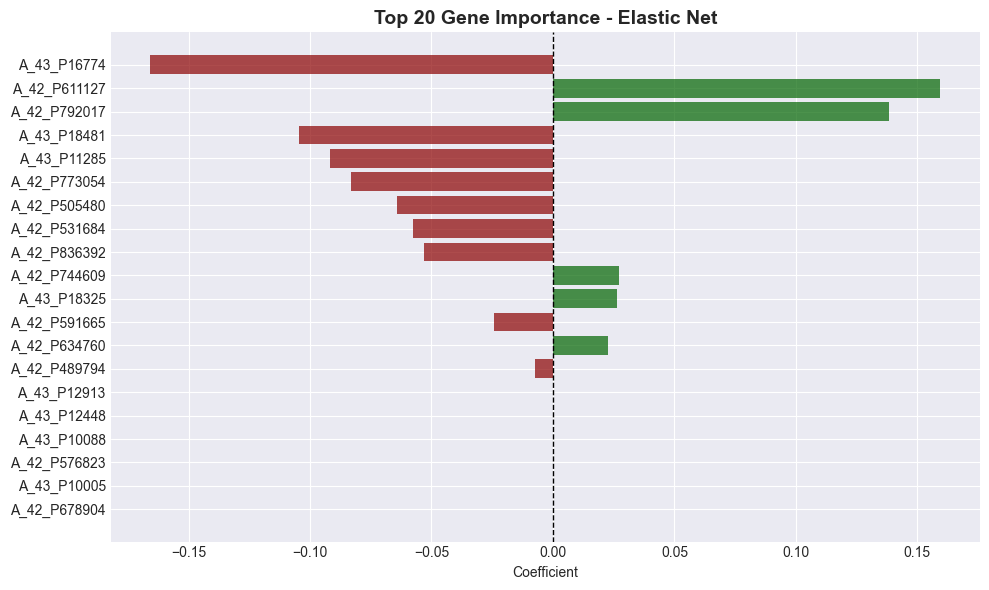

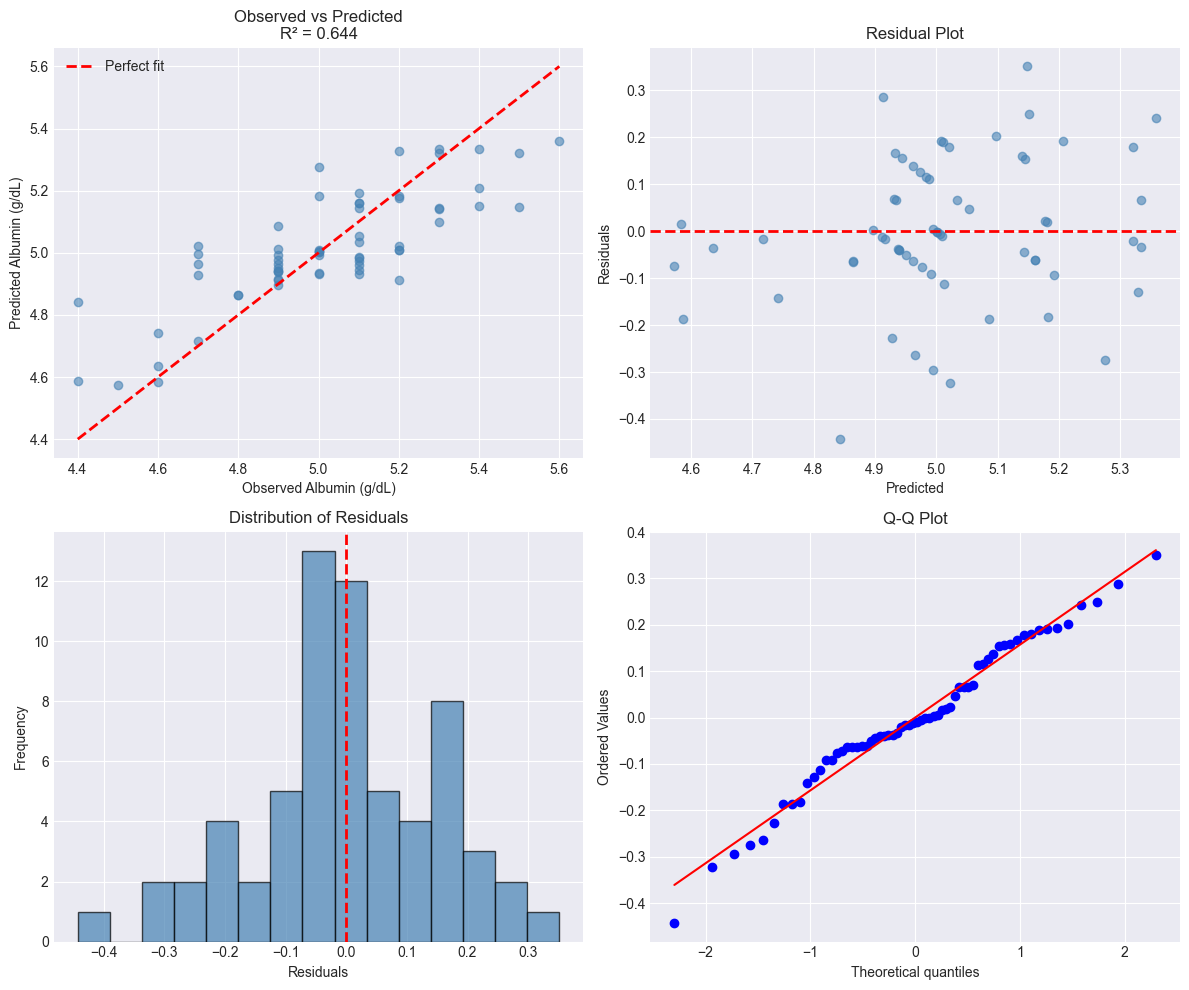


SUMMARY TABLE OF RESULTS

             Metric       Value
              Model Elastic Net
     n observations          64
 p genes (original)        3116
 p genes (selected)         100
          Ratio p/n        48.7
     CV RMSE (mean)      0.1897
       CV RMSE (sd)      0.0358
      CV MAE (mean)      0.1466
       CV R² (mean)      0.2631
      Training RMSE      0.1542
        Training R²      0.6442
Stable genes (≥80%)          62

COMPLETED

Saved files:
- final_highdim_regression_enet.pkl
- selected_features_regression.pkl
- cv_highdim_regression_results.csv
- summary_highdim_regression.csv
- gene_coefficients.csv


In [ ]:
# ----------------------------------------------------------------------------
# --- RE-RUNNING OF BEST MODEL ON ENTIRE DATASET
# ----------------------------------------------------------------------------

print("\n" + "="*60)
print("RE-RUNNING THE BEST MODEL ON THE DATA")
print("="*60)

# Feature selection on the entire dataset
best_features = feature_selection_correlation(X, y, top_n=100)
X_final = X[best_features]

print(f"\nUsed Features: {len(best_features)}")
print(f"Matrix dimension: {X_final.shape}")

# Re-run
from sklearn.base import clone
final_model = clone(models[best_model_code])
final_model.fit(X_final, y)

# save
import pickle
with open(f'final_highdim_regression_{best_model_code}.pkl', 'wb') as f:
    pickle.dump(final_model, f)
    
with open('selected_features_regression.pkl', 'wb') as f:
    pickle.dump(best_features, f)

# --- BEST MODEL ANALYSIS: ELASTIC NET

if best_model_code in ['ridge', 'lasso', 'enet']:
    # Prediction
    y_pred_train = final_model.predict(X_final)
    train_metrics = compute_metrics(y, y_pred_train)
    
    print(f"\nTraining Performance:")
    print(f"RMSE: {train_metrics['RMSE']:.4f}")
    print(f"MAE: {train_metrics['MAE']:.4f}")
    print(f"R2: {train_metrics['R2']:.4f}")
    
    # Coefficients
    intercept = final_model.intercept_
    coefs = final_model.coef_
    
    coef_df = pd.DataFrame({
        'Gene': best_features,
        'Coefficient': coefs
    })
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    coef_df['Direction'] = coef_df['Coefficient'].apply(
        lambda x: 'Increase Albumin' if x > 0 else 'Decrease Albumin'
    )
    
    print(f"\nIntercept: {intercept:.4f}")
    
    if best_model_code == 'ridge':
        print(f"! Ridge uses all {len(coefs)} genes (no sparsity)")
    elif best_model_code == 'lasso':
        non_zero = (coefs != 0).sum()
        print(f"! Lasso selects {non_zero} genes of {len(coefs)}")
    
    print(f"\n 20 most important genes")
    print(coef_df[['Gene', 'Coefficient', 'Direction']].head(20).to_string(index=False))
    
    # Plot coefficients top 20
    fig, ax = plt.subplots(figsize=(10, 6))
    top20 = coef_df.head(20).sort_values('Abs_Coefficient', ascending=True)
    colors = ['darkgreen' if c > 0 else 'darkred' for c in top20['Coefficient']]
    
    ax.barh(range(len(top20)), top20['Coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['Gene'])
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Coefficient')
    ax.set_title(f'Top 20 Gene Importance - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Observed vs Predicted
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Scatter
    axes[0, 0].scatter(y, y_pred_train, alpha=0.6, color='steelblue')
    axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 
                    'r--', lw=2, label='Perfect fit')
    axes[0, 0].set_xlabel('Observed Albumin (g/dL)')
    axes[0, 0].set_ylabel('Predicted Albumin (g/dL)')
    axes[0, 0].set_title(f'Observed vs Predicted\nR² = {train_metrics["R2"]:.3f}')
    axes[0, 0].legend()
    
    # Residuals
    residuals = y - y_pred_train
    axes[0, 1].scatter(y_pred_train, residuals, alpha=0.6, color='steelblue')
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    
    # Histogram residuals
    axes[1, 0].hist(residuals, bins=15, edgecolor='black', 
                    alpha=0.7, color='steelblue')
    axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Residuals')
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

# --- SUMMARY

print("\n" + "="*60)
print("SUMMARY TABLE OF RESULTS")
print("="*60)

summary_data = {
    'Metric': [
        'Model',
        'n observations',
        'p genes (original)',
        'p genes (selected)',
        'Ratio p/n',
        'CV RMSE (mean)',
        'CV RMSE (sd)',
        'CV MAE (mean)',
        'CV R² (mean)',
        'Training RMSE',
        'Training R²',
        'Stable genes (≥80%)'
    ],
    'Value': [
        best_model_name,
        str(n),
        str(p),
        str(len(best_features)),
        f"{p/n:.1f}",
        f"{best_model_row['RMSE_mean']:.4f}",
        f"{best_model_row['RMSE_sd']:.4f}",
        f"{best_model_row['MAE_mean']:.4f}",
        f"{best_model_row['R2_mean']:.4f}",
        f"{train_metrics['RMSE']:.4f}" if 'train_metrics' in locals() else 'N/A',
        f"{train_metrics['R2']:.4f}" if 'train_metrics' in locals() else 'N/A',
        str(len(stable_genes))
    ]
}

summary_table = pd.DataFrame(summary_data)
print("\n" + summary_table.to_string(index=False))

# save results

cv_summary.to_csv('cv_highdim_regression_results.csv', index=False)
summary_table.to_csv('summary_highdim_regression.csv', index=False)

if best_model_code in ['ridge', 'lasso', 'enet']:
    coef_df.to_csv('gene_coefficients.csv', index=False)

print("\n" + "="*60)
print("COMPLETED")
print("="*60)
print("\nSaved files:")
print(f"- final_highdim_regression_{best_model_code}.pkl")
print("- selected_features_regression.pkl")
print("- cv_highdim_regression_results.csv")
print("- summary_highdim_regression.csv")
if best_model_code in ['ridge', 'lasso', 'enet']:
    print("- gene_coefficients.csv")